## Using GP 

to do dimensionality reduction on $(r, n_1, n_2)$. We should need only 2 parameters for each axis, $l, \sigma_0$

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from gal_goku import summary_stats
from gal_goku import utils
import gpflow
from gpflow.utilities import print_summary
import tensorflow as tf

def normalize(X,Y):
    """
    """
    X_min, X_max = tf.reduce_min(X, axis=0), tf.reduce_max(X, axis=0)

    X = (X - X_min) / (X_max - X_min)
    medind = np.argsort(np.mean(Y, axis=1))[np.shape(Y)[0]//2]
    mean_func = Y[medind,:]
    #print(f'mean_func: {mean_func}')

    return mean_func, X_min, X_max


def dim_reduc_gp(fid = 'HF', r_range=(0.1, np.inf), kernels={'kernels':[gpflow.kernels.RBF], 'loc':[], 'train_loc':True}, lik_var=None, log_y=True, subsample=False):
    """
    Development code for finding best GP model for dimensionality reduction
    Parameters
    ----------
    r_range : tuple
        Range of r to consider for fitting the GP model. supported ranege is (0.1, 80) for now
    kernels : dict
        Dictionary of kernel functions to use. The key 'kernels' should be a list of kernel functions
        The key 'loc' should be a list of change points for the ChangePoints kernel
    lik_var : float
        Known variance of the likelihood function. If None, it is optimized
    log_y : bool
        Whether to train the model in log scale on y
    """

    data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
    xi = summary_stats.Xi(data_dir, fid, logging_level='ERROR')
    all_mass_bins =  np.around([12.1, 11.6 , 11.1], 2)
    fig, ax = plt.subplots(all_mass_bins.size, all_mass_bins.size, sharex=True, figsize=(12, 7))
    fig_full, ax_full = plt.subplots(1,2, figsize=(10, 4))
    fig_one_sim, ax_one_sim = plt.subplots(1,3, figsize=(15, 4))
    m_count = 0
    bad_sims = []
    for i in range(all_mass_bins.size):
        m1 = all_mass_bins[i]
        for j in range(i, all_mass_bins.size):
            m_count +=1
            #print(i,j, all_mass_bins)
            m2 = all_mass_bins[j]
            mass_bins =  [m1, m2]
            rbins , _, corrs = xi.load_all(mass_bins)
            ind_rbin = (rbins >= r_range[0])*(rbins <= r_range[1])
            rbins_all = rbins[ind_rbin].reshape(rbins[ind_rbin].size, 1)
            rbins_all = np.log10(rbins_all)
            corrs = np.copy(corrs[:,ind_rbin].squeeze())
            if subsample:
                sample = np.random.choice(corrs.shape[0], 10, replace=False)
            else:
                sample = np.arange(corrs.shape[0])
            all_frac_err = []
            for c_counter, c in enumerate(sample):
                corr_train = np.copy(corrs[c,:])
                # Some bins have negative correlation, remove them
                # from the training set
                if np.any(corr_train < 0):
                    full_size = corr_train.size
                    ind = np.where(corr_train >= 0)[0]
                    corr_train = corr_train[ind]
                    rbins = rbins_all[ind]
                    print(f'{full_size - ind.size} Negative correlation in {mass_bins} of sim {c} removed')
                    if ind.size < 5:
                        bad_sims.append([m1, m2, c])
                        continue
                else:
                    rbins = rbins_all
                
                # train in log scale on y
                if log_y:
                    corr_train = np.log10(corr_train)
                corr_train = corr_train.reshape(corr_train.size, 1)
                ## Normalize
                mean_func, X_min, X_max = normalize(rbins, corr_train)
                X_train = (rbins - X_min) / (X_max - X_min)
                dtype = mean_func.dtype
                for dout in range(corr_train.shape[1]):
                    class MeanFunction(gpflow.mean_functions.MeanFunction):
                        def __call__(self, X):
                            return tf.convert_to_tensor(mean_func[dout], dtype=dtype)


                ## GP model
                if len(kernels['kernels']) == 1:
                    kernel = kernels['kernels'][0]()
                    model = gpflow.models.GPR(data=(X_train, corr_train), kernel=kernel, mean_function=MeanFunction())
                else:
                    ker_inst = [ k() for k in kernels['kernels']]
                    kernel = gpflow.kernels.ChangePoints(ker_inst, locations=np.log10(kernels['loc']))
                # Use the GPR model if the likliehood error is fixed for 
                # all the data points
                    model = gpflow.models.GPR(data=(X_train, corr_train), kernel=kernel, mean_function=MeanFunction())
                    
                if lik_var is not None:
                    model.likelihood.variance.assign(lik_var)
                    # Make it non-trainable
                    gpflow.set_trainable(model.likelihood.variance, False)
                if not kernels['train_loc']:
                    gpflow.set_trainable(model.kernel.locations, False)
                        
                    
                # Fix the noise variance to known value or not
                #model.likelihood.variance.assign(1e-5)
                #gpflow.set_trainable(model.likelihood.variance, False)
                
                ## Optimize
                opt = gpflow.optimizers.Scipy()
                opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
                #print_summary(model)
                



                pred_bins, _ = model.predict_f(X_train)
                pred_bins = pred_bins.numpy().flatten()
                # if log_y, convert back to linear scale for plotting
                if log_y:
                    corr_train = 10**corr_train
                    pred_bins = 10**pred_bins
                frac_err = pred_bins / corr_train.flatten() - 1
                ax[i,j].plot(10**rbins,frac_err , f'C{i}', alpha=0.3)
                all_frac_err.append(frac_err)


                # Plot the smallest mass bins for all sims
                if i == all_mass_bins.size-1 and j == all_mass_bins.size-1:
                    ## Predict
                    rbins_fine = np.linspace(rbins[0], rbins[-1], 1000)
                    X_fine = (rbins_fine - X_min) / (X_max - X_min)
                    X_fine = X_fine[:, np.newaxis]
                    pred_fine, _ = model.predict_f(X_fine)
                    pred_fine = pred_fine.numpy().flatten()
                    # if log_y, convert back to linear scale for plotting
                    if log_y:
                        pred_fine = 10**pred_fine
                    r_nonlog = 10**rbins_fine.flatten()
                    ax_full[0].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{c}')
                    ax_full[1].plot(r_nonlog, pred_fine, alpha=0.3, color=f'C{c}')
                    r_nonlog = 10**rbins.flatten()
                    ax_full[0].scatter(r_nonlog, corr_train, color=f'C{c}', alpha=0.3, marker='x')
                    ax_full[1].scatter(r_nonlog, corr_train.flatten(), color=f'C{c}', alpha=0.3, marker='x')

                    
                if c_counter == 2:
                    # Predict
                    rbins_fine = np.linspace(rbins[0], rbins[-1], 1000)
                    X_fine = (rbins_fine - X_min) / (X_max - X_min)
                    X_fine = X_fine[:, np.newaxis]
                    pred_fine, _ = model.predict_f(X_fine)
                    pred_fine = pred_fine.numpy().flatten()
                    # if log_y, convert back to linear scale for plotting
                    if log_y:
                        pred_fine = 10**pred_fine

                    r_nonlog = 10**rbins_fine.flatten()
                    ax_one_sim[0].plot(r_nonlog, pred_fine, alpha=0.5, color=f'C{m_count}', ls='--')
                    ax_one_sim[1].plot(r_nonlog, pred_fine, alpha=0.5, color=f'C{m_count}', ls='--')
                    ax_one_sim[2].plot(r_nonlog, pred_fine, alpha=0.5, color=f'C{m_count}', ls='--')
                    r_nonlog = 10**rbins.flatten()
                    ax_one_sim[0].plot(r_nonlog, corr_train, color=f'C{m_count}', alpha=0.3, marker='x', label=f'{m1} - {m2}', lw=4)
                    ax_one_sim[1].plot(r_nonlog, corr_train.flatten(), color=f'C{m_count}', alpha=0.3, marker='x', label=f'{m1} - {m2}', lw=4)
                    ax_one_sim[2].plot(r_nonlog, corr_train.flatten(), color=f'C{m_count}', alpha=0.3, marker='x', label=f'{m1} - {m2}', lw=4)
            
            # Cannot plot the median of all yet as we eahc sim has different non-nan bins
            #ax[i,j].plot(rbins, np.median(all_frac_err, axis=0), color=f'k', lw=2, label='median', ls='--')
            ax[i,j].set_title(f'{m1} - {m2}')
            ax[i,j].set_xscale('log')
            ax[i,j].grid()
            ax[i,j].set_ylim(-0.2, 0.2)
            for i in range(2):
                ax_full[i].grid()
                ax_full[i].set_xscale('log')
                ax_full[i].legend()
                ax_one_sim[i].set_xscale('log')
            for i in range(3):
                ax_one_sim[i].grid()
                ax_one_sim[i].legend()
            ax_full[1].set_yscale('log')
            ax_full[0].set_xlim(0.1, 3)
            ax_full[0].set_ylim(0, 100)
            ax_full[1].set_ylim(1e-4, 1e1)
            ax_full[1].set_xlim(3, 80)
            ax_full[0].set_ylabel(r'$\xi(r)$')
            ax_full[1].set_ylabel(r'$r \times \xi(r)$')
            fig_full.suptitle(f'r_range: {r_range} - mass_bins: {mass_bins} - all sims')

            ax_one_sim[0].set_xlim(0.1, 3)
            ax_one_sim[1].set_xlim(3, 60)
            ax_one_sim[2].set_xlim(60, 80)
            ax_one_sim[0].set_ylim(0, 100)
            ax_one_sim[1].set_ylim(1e-2, 1e1)
            ax_one_sim[2].set_ylim(1e-3, 1e-1)
            ax_one_sim[1].set_yscale('log')
            ax_one_sim[2].set_yscale('log')

    print_summary(model)
    
    fig.suptitle(f'r_range: {r_range}')
    fig.tight_layout()
    fig_full.tight_layout()
    print(f'bad_sims: {bad_sims}')
            

2025-03-05 14:43:42.900071: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 14:43:42.903527: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 14:43:42.915541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741207422.935917 2208231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741207422.941239 2208231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 14:43:42.961740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2025-03-05 12:11:07.787654: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1 Negative correlation in [12.1, 12.1] of sim 3 removed
6 Negative correlation in [12.1, 12.1] of sim 15 removed
1 Negative correlation in [12.1, 12.1] of sim 17 removed
1 Negative correlation in [12.1, 12.1] of sim 20 removed


/tmp/ipykernel_2197073/4068911904.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


2 Negative correlation in [12.1, 11.6] of sim 15 removed
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.47504    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.162754   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 4.7175e-05 │
╘══════════════

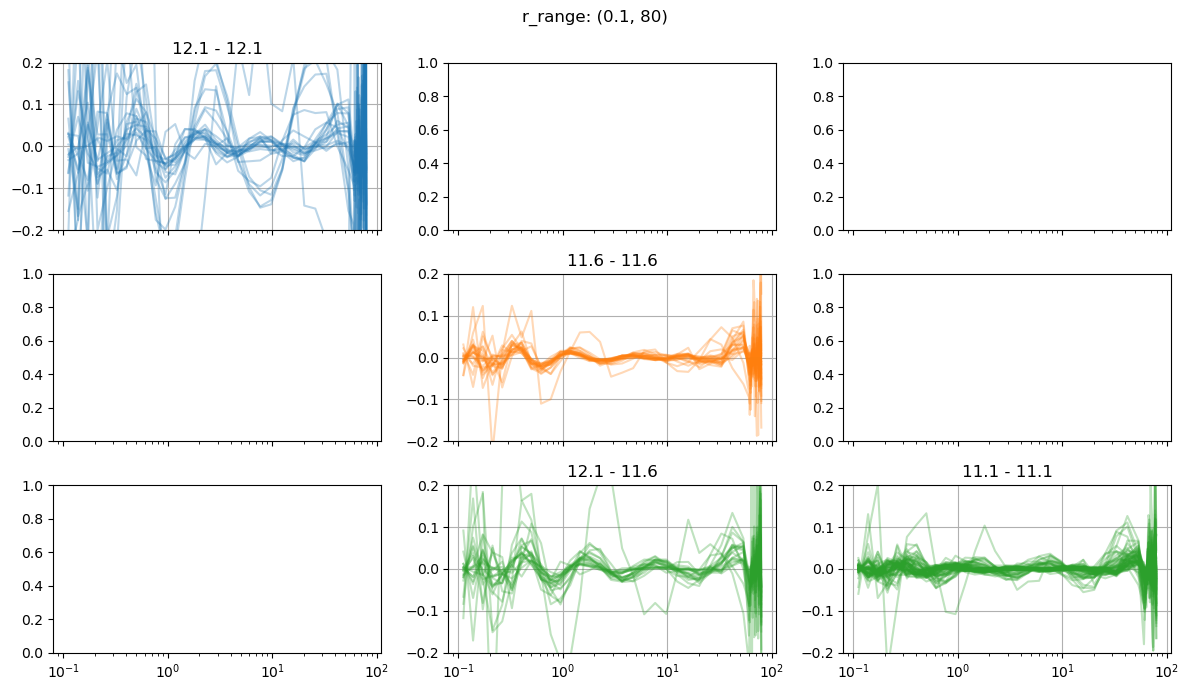

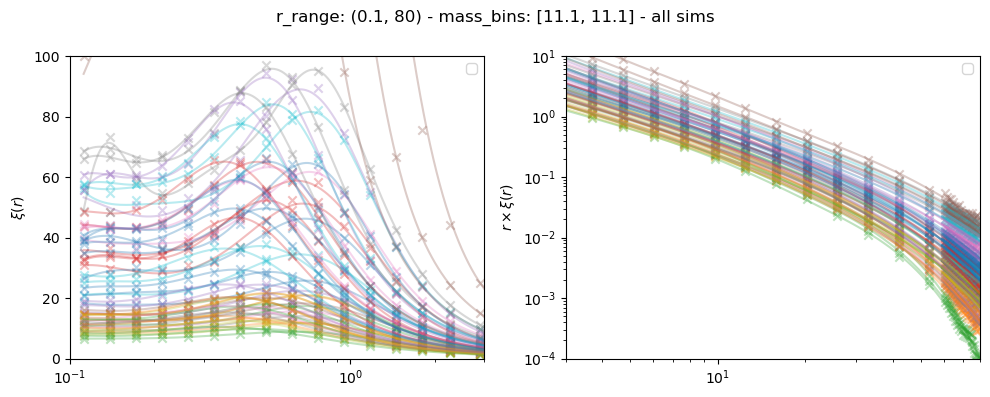

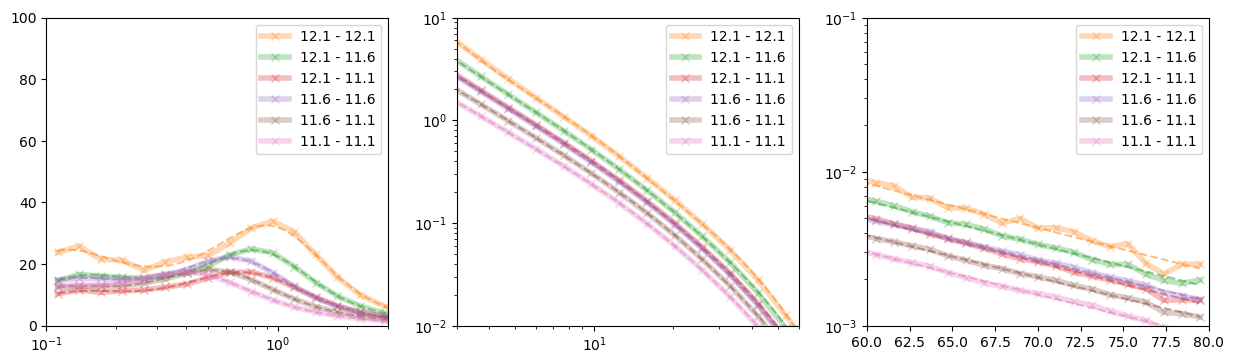

In [2]:
dim_reduc_gp(r_range=(0.1, 80))


15 Negative correlation in [12.1, 12.1] of sim 403 removed
1 Negative correlation in [12.1, 12.1] of sim 71 removed
2 Negative correlation in [12.1, 12.1] of sim 220 removed
5 Negative correlation in [12.1, 12.1] of sim 61 removed
6 Negative correlation in [12.1, 12.1] of sim 119 removed
5 Negative correlation in [12.1, 12.1] of sim 454 removed
2 Negative correlation in [12.1, 12.1] of sim 381 removed
9 Negative correlation in [12.1, 12.1] of sim 456 removed
1 Negative correlation in [12.1, 12.1] of sim 383 removed
24 Negative correlation in [12.1, 12.1] of sim 438 removed


/tmp/ipykernel_2197073/4068911904.py:181: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


1 Negative correlation in [12.1, 11.6] of sim 86 removed
1 Negative correlation in [12.1, 11.6] of sim 161 removed
15 Negative correlation in [12.1, 11.6] of sim 263 removed
6 Negative correlation in [12.1, 11.6] of sim 480 removed
14 Negative correlation in [12.1, 11.6] of sim 486 removed
10 Negative correlation in [12.1, 11.6] of sim 420 removed
6 Negative correlation in [12.1, 11.6] of sim 250 removed
3 Negative correlation in [12.1, 11.1] of sim 132 removed
6 Negative correlation in [12.1, 11.1] of sim 298 removed
18 Negative correlation in [12.1, 11.1] of sim 467 removed
1 Negative correlation in [12.1, 11.1] of sim 493 removed
3 Negative correlation in [12.1, 11.1] of sim 242 removed
11 Negative correlation in [12.1, 11.1] of sim 186 removed
2 Negative correlation in [12.1, 11.1] of sim 351 removed
11 Negative correlation in [12.1, 11.1] of sim 122 removed
3 Negative correlation in [11.6, 11.6] of sim 423 removed
2 Negative correlation in [11.6, 11.6] of sim 397 removed
7 Negativ

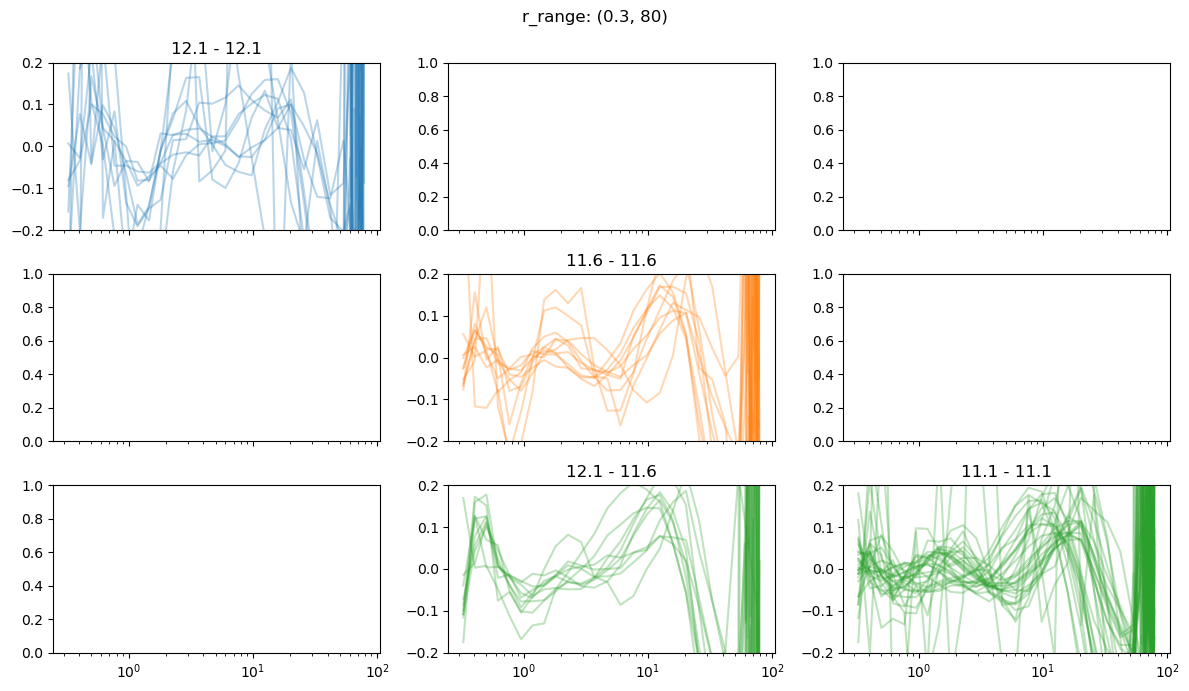

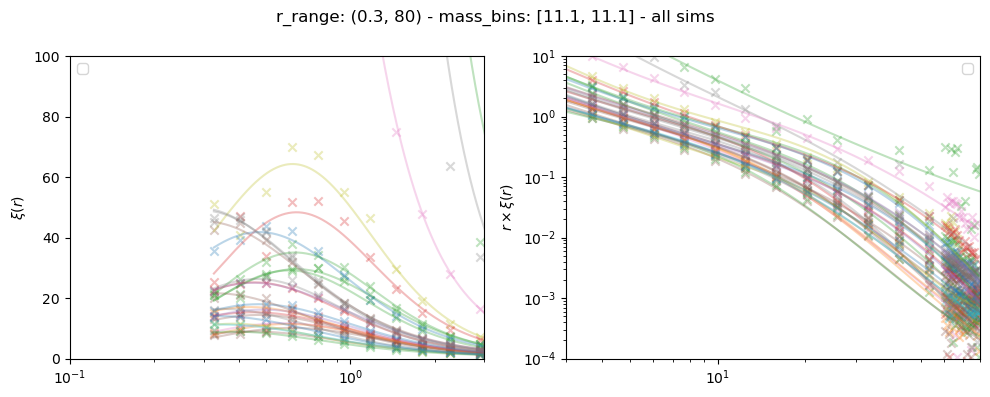

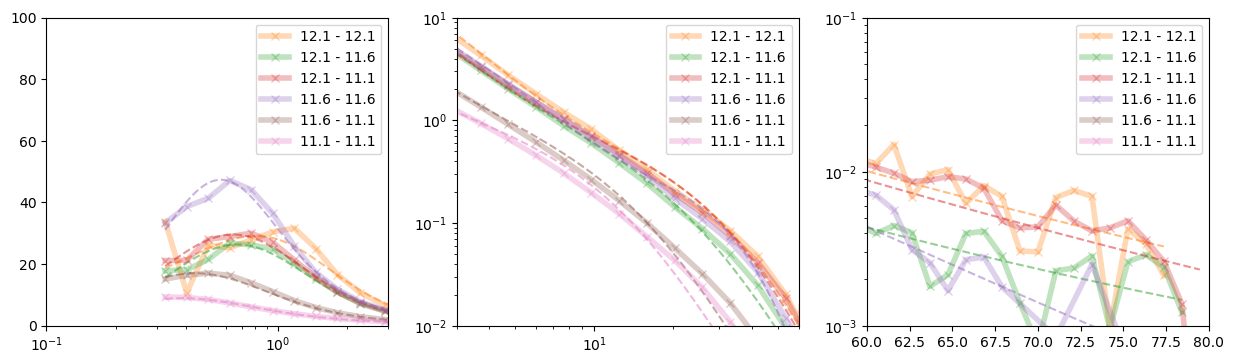

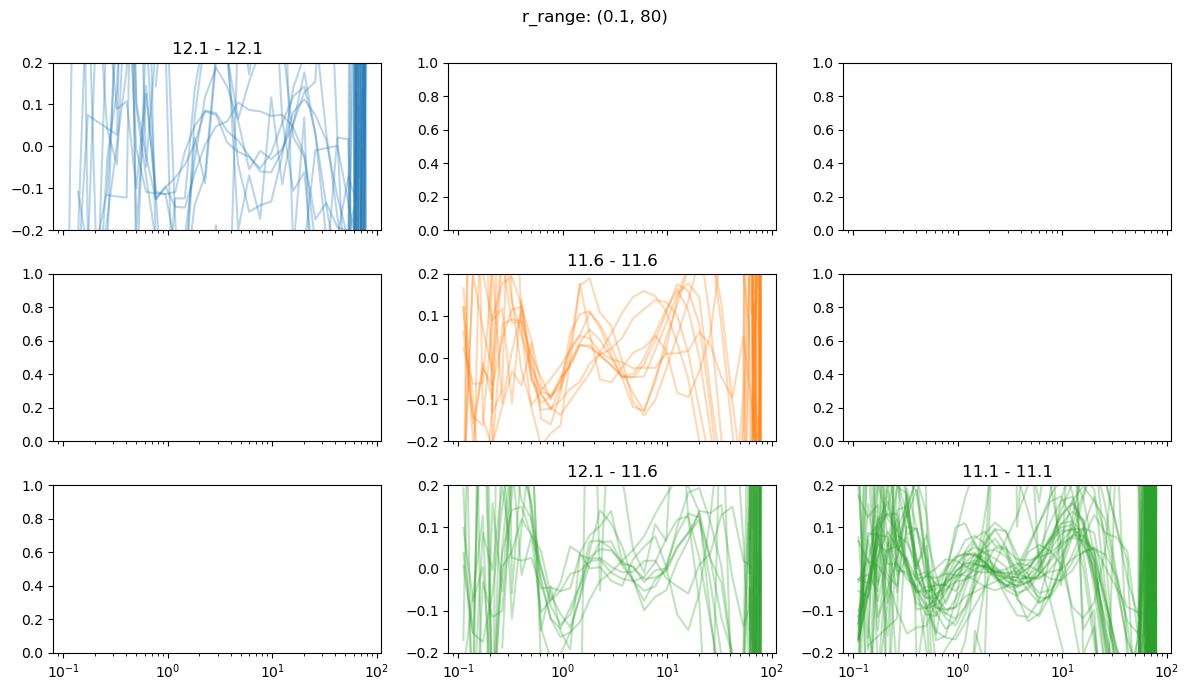

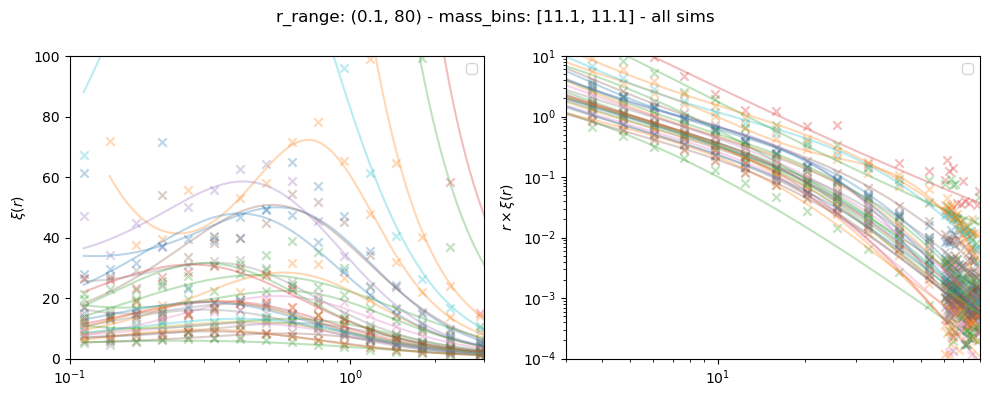

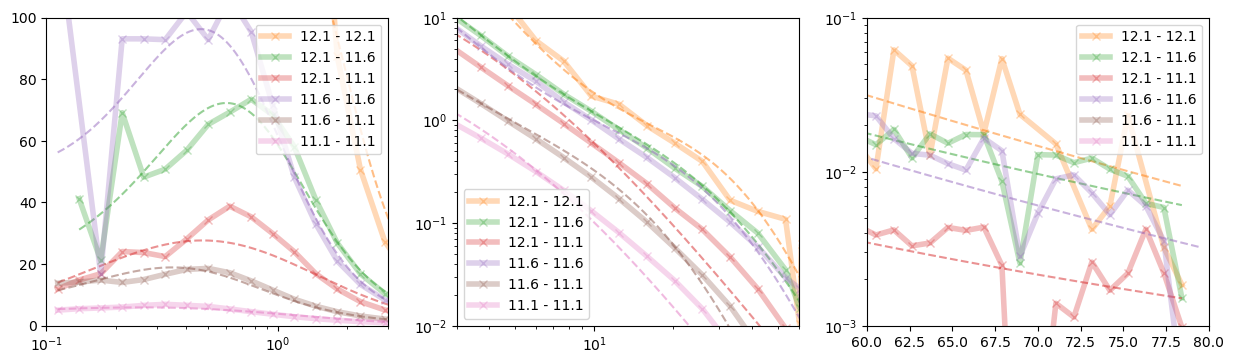

In [4]:
dim_reduc_gp(r_range=(0.3, 80), fid='L2', subsample=True)
dim_reduc_gp(r_range=(0.1, 80), fid='L2', subsample=True)

The comaprison above shows fixing the likliehood variance to 0.01 does a bad job where the fucntion itself is small (large scales). So the case with a learned the varaicne does a better job. 

Two solutions:

1. Have 2 different varaince for small and large scales
2. Use `GPR.kernels.CahnegPoints()` to train 2 different GPs for the small and large scales, so the relative variance between these two scales doesn't matter.

1 Negative correlation in [12.1, 12.1] of sim 3 removed
6 Negative correlation in [12.1, 12.1] of sim 15 removed
1 Negative correlation in [12.1, 12.1] of sim 17 removed
1 Negative correlation in [12.1, 12.1] of sim 20 removed


/tmp/ipykernel_2208231/1438485769.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


2 Negative correlation in [12.1, 11.6] of sim 15 removed
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.89744               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.10996177671725019   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──

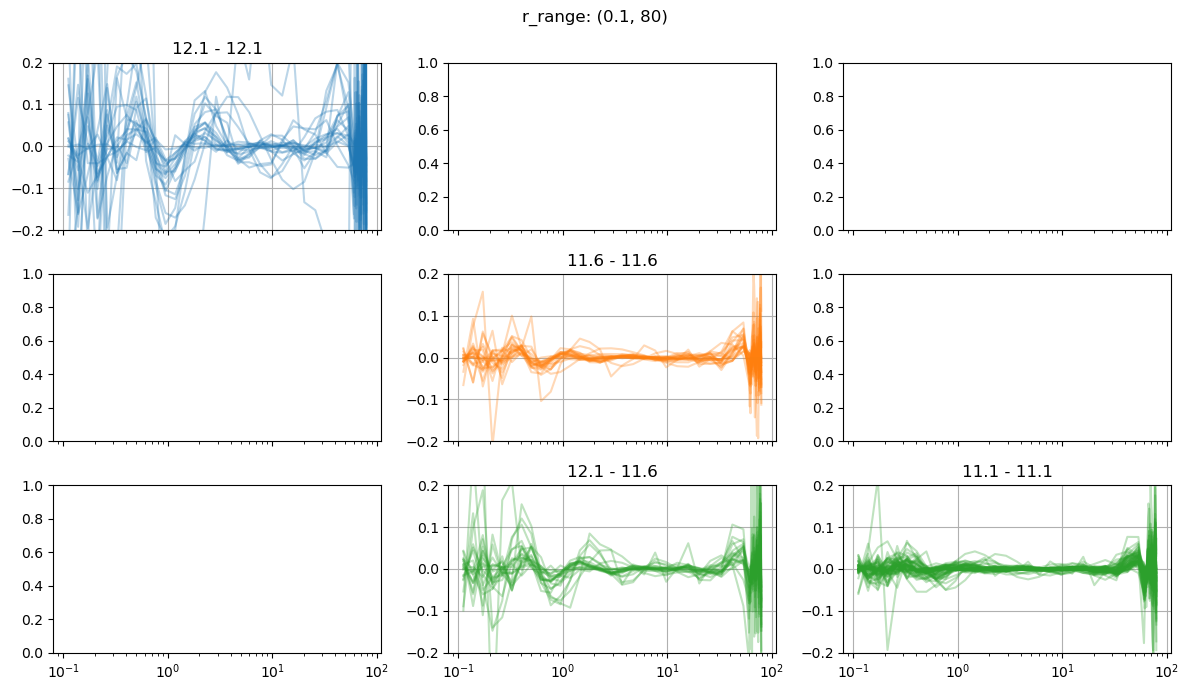

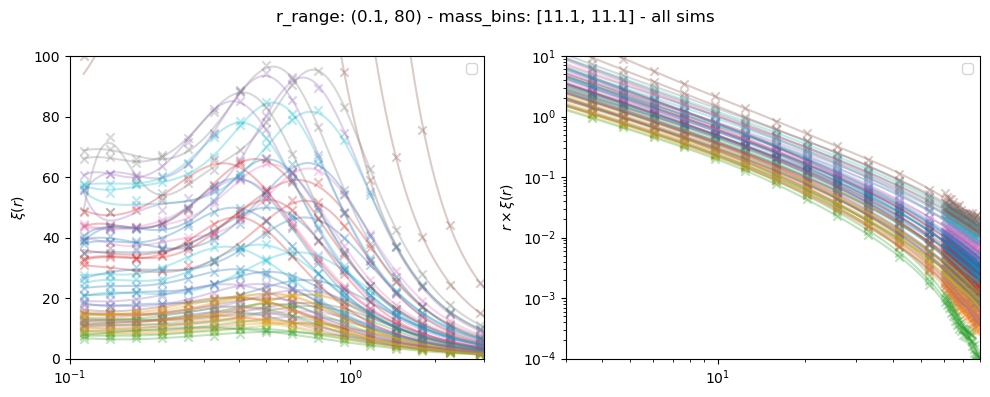

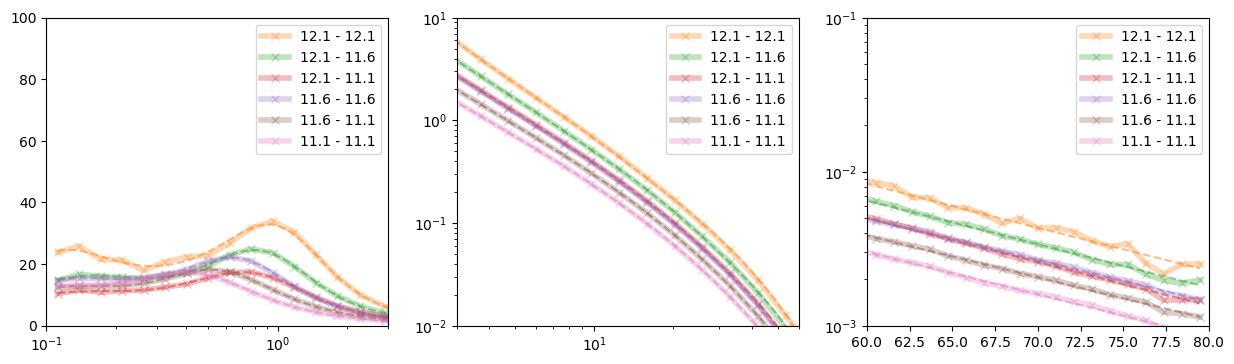

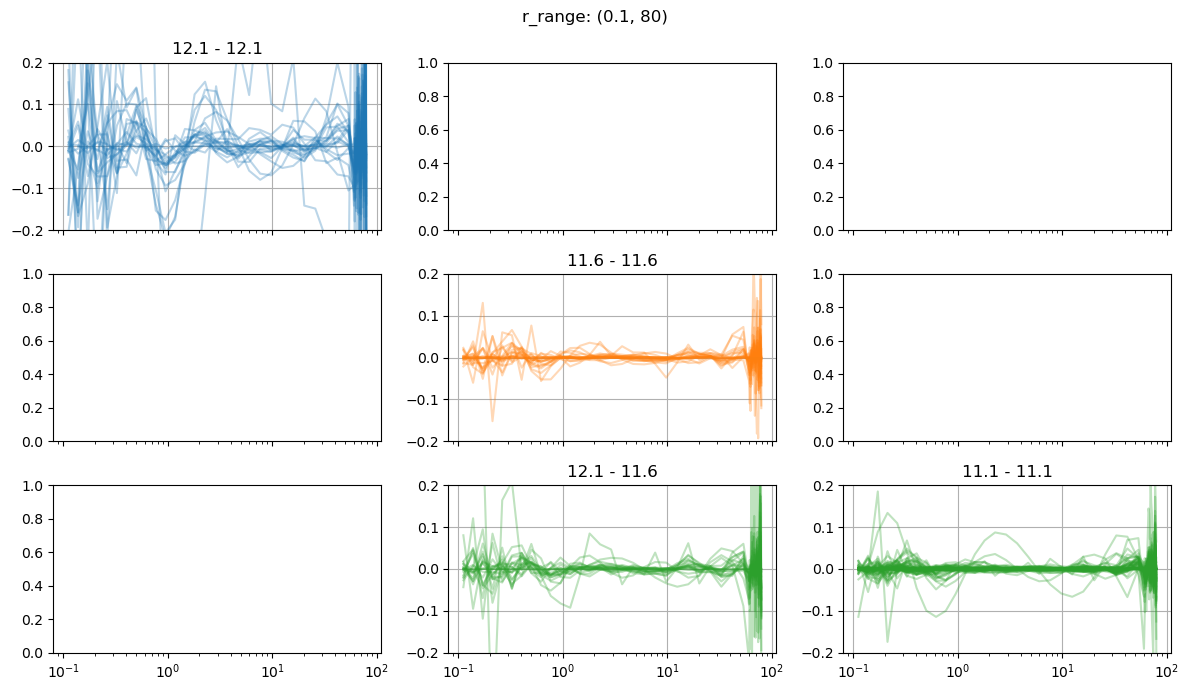

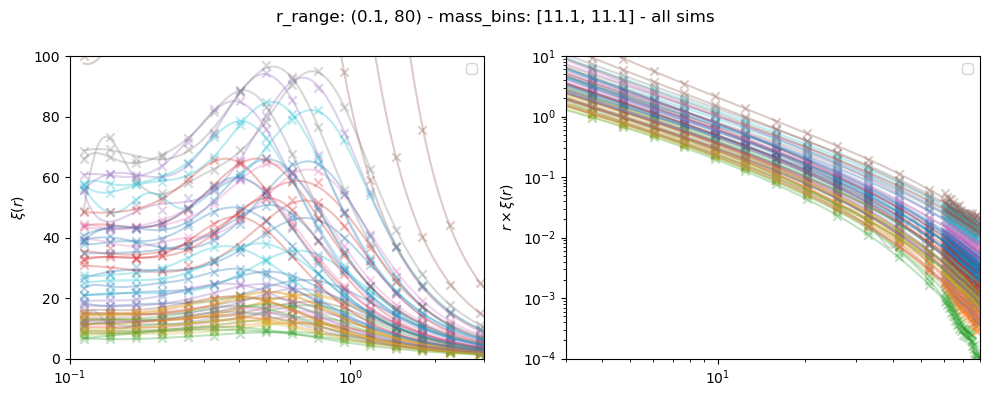

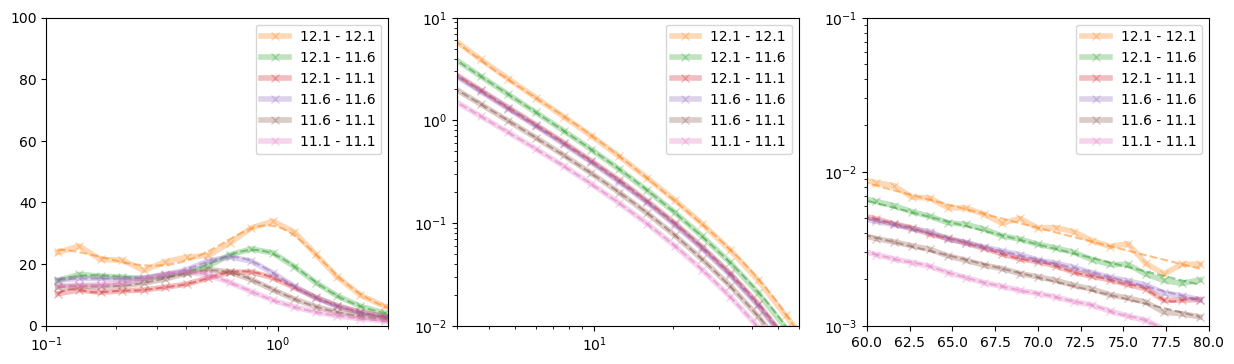

In [3]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1, 10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel)

kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1,10], 'train_loc':True}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel)

6 Negative correlation in [12.1, 12.1] of sim 144 removed


2025-03-05 14:44:32.296205: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


5 Negative correlation in [12.1, 12.1] of sim 195 removed
13 Negative correlation in [12.1, 12.1] of sim 362 removed
14 Negative correlation in [12.1, 12.1] of sim 345 removed
8 Negative correlation in [12.1, 12.1] of sim 377 removed
9 Negative correlation in [12.1, 12.1] of sim 479 removed
4 Negative correlation in [12.1, 12.1] of sim 453 removed
5 Negative correlation in [12.1, 12.1] of sim 249 removed
5 Negative correlation in [12.1, 12.1] of sim 491 removed
13 Negative correlation in [12.1, 12.1] of sim 553 removed


/tmp/ipykernel_2208231/1438485769.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_full[i].legend()


1 Negative correlation in [12.1, 11.6] of sim 427 removed
2 Negative correlation in [12.1, 11.6] of sim 489 removed
10 Negative correlation in [12.1, 11.6] of sim 450 removed
6 Negative correlation in [12.1, 11.6] of sim 516 removed
2 Negative correlation in [12.1, 11.6] of sim 94 removed
4 Negative correlation in [12.1, 11.6] of sim 407 removed
3 Negative correlation in [12.1, 11.6] of sim 270 removed
7 Negative correlation in [12.1, 11.1] of sim 391 removed
7 Negative correlation in [12.1, 11.1] of sim 352 removed
2 Negative correlation in [12.1, 11.1] of sim 313 removed
16 Negative correlation in [12.1, 11.1] of sim 194 removed
17 Negative correlation in [12.1, 11.1] of sim 417 removed
1 Negative correlation in [12.1, 11.1] of sim 257 removed
1 Negative correlation in [11.6, 11.6] of sim 491 removed
15 Negative correlation in [11.6, 11.6] of sim 53 removed
10 Negative correlation in [11.6, 11.6] of sim 294 removed
1 Negative correlation in [11.6, 11.6] of sim 28 removed
9 Negative c

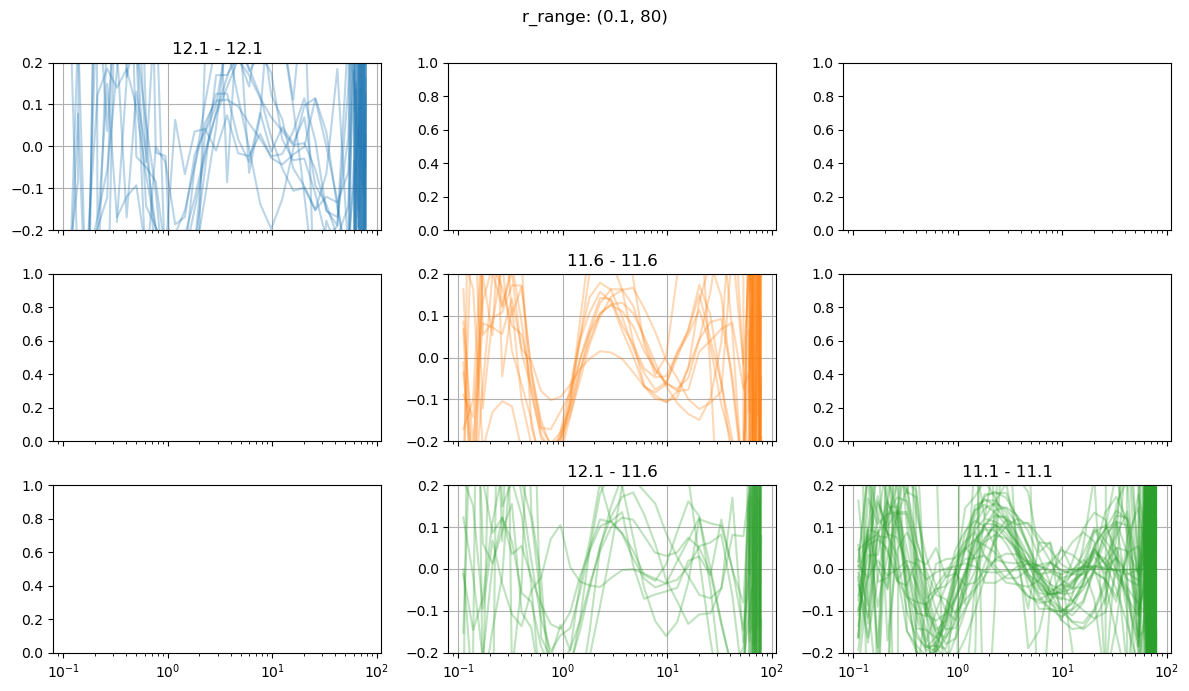

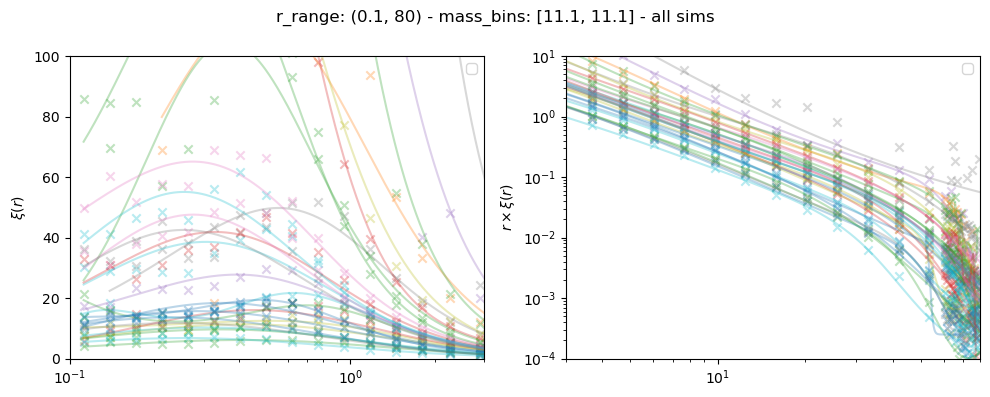

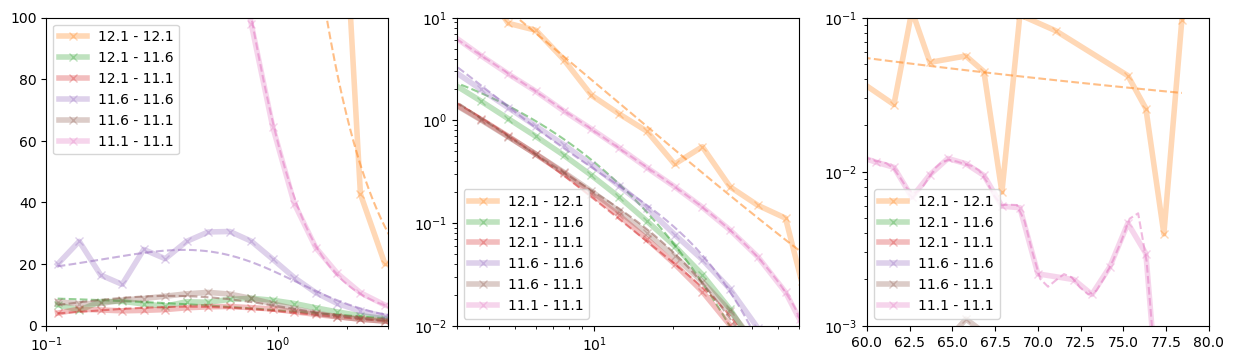

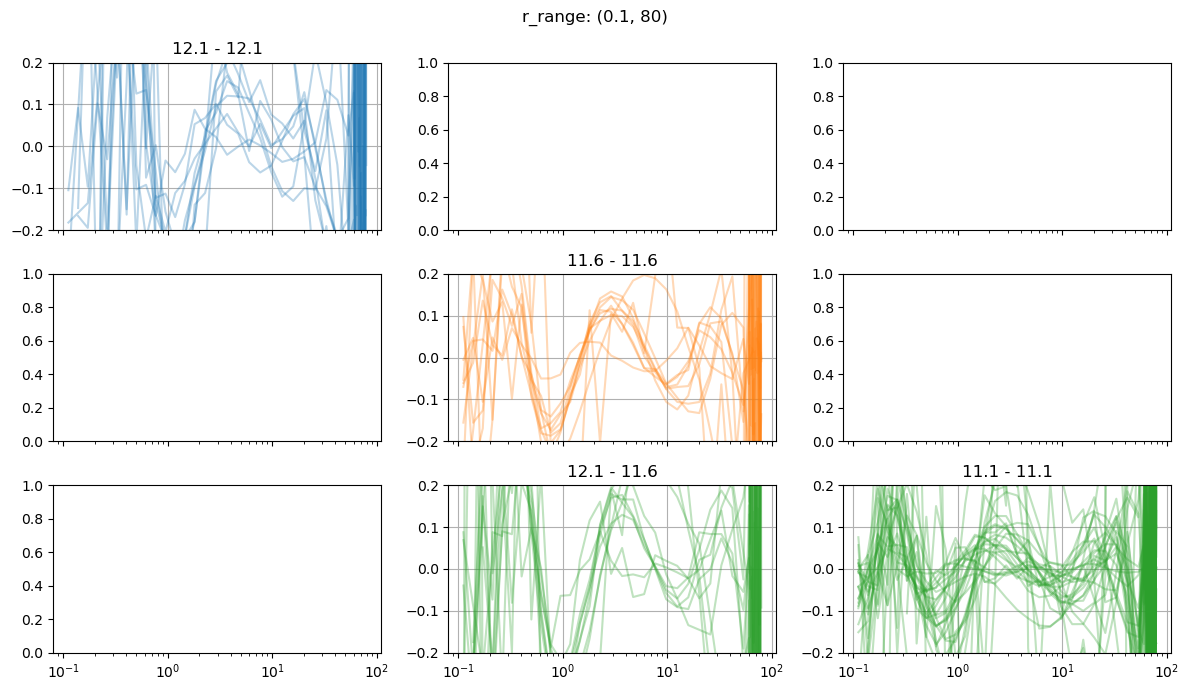

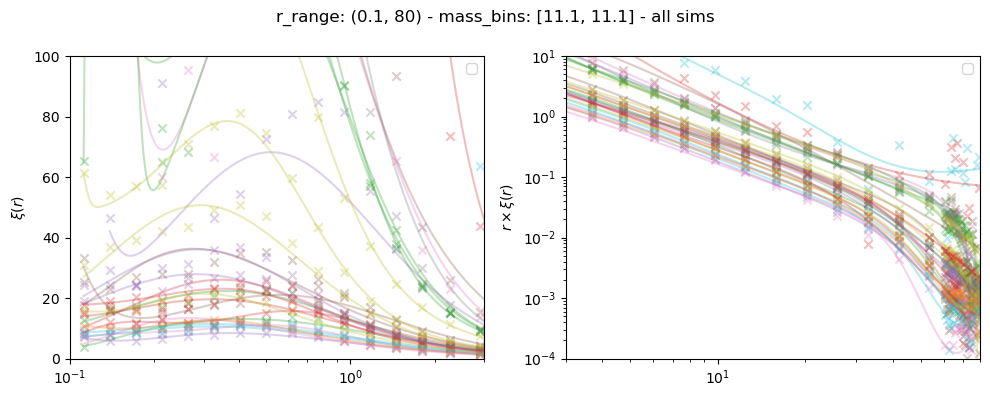

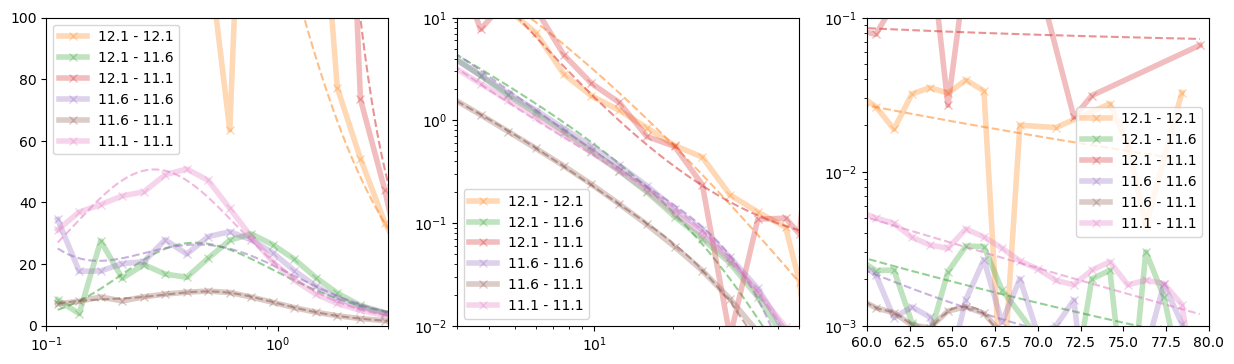

In [2]:
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1,10], 'train_loc':True}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel, fid='L2', subsample=True)
kernel = {'kernels':[gpflow.kernels.RBF, gpflow.kernels.RBF, gpflow.kernels.RBF], 'loc':[1,10], 'train_loc':False}
dim_reduc_gp(r_range=(0.1, 80), kernels=kernel, fid='L2', subsample=True)

## Constrain the ucertainty:

In [1]:
import importlib
from gal_goku import  summary_stats
importlib.reload(summary_stats)
data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
xi = summary_stats.Xi(data_dir, 'HF', logging_level='INFO')
xi._sim_fit_gp_r(xi.sim_tags[0])

2025-03-14 15:15:43.961676: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 15:15:43.964477: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 15:15:43.973946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741983343.989722 2738604 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741983343.994421 2738604 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 15:15:44.011123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

summary_stats | 03/14/2025 03:15:47 PM | Rank 0 | INFO  |  Total sims files: 21 in /home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/HF
summary_stats | 03/14/2025 03:15:47 PM | Rank 0 | INFO  |  Fitting GP, prog 0/231


/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:610: RuntimeWarning: invalid value encountered in log10
  corrs = np.log10(corrs[:,ind_rbins])
2025-03-14 15:15:47.302392: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


summary_stats | 03/14/2025 03:15:49 PM | Rank 0 | WARNING  |  Optimization did not converge for compressed_10p_Box1000_Part3000_0207 at mass pair [13. 13.]
summary_stats | 03/14/2025 03:15:50 PM | Rank 0 | WARNING  |  Optimization did not converge for compressed_10p_Box1000_Part3000_0207 at mass pair [13.  12.8]


(array([ 0.21268578,  0.26343238,  0.32628708,  0.40413884,  0.50056595,
         0.62000047,  0.76793194,  0.9511597 ,  1.17810543,  1.45920017,
         1.80736382,  2.27499553,  2.90060912,  3.69826365,  4.71526961,
         6.01194766,  7.66520638,  9.77310384, 12.46066368, 15.88729045,
        20.25622426, 25.82659532, 32.9287935 , 41.98406441, 53.52949432,
        60.52631579, 61.57894737, 62.63157895, 63.68421053, 64.73684211,
        65.78947368, 66.84210526, 67.89473684, 68.94736842, 70.        ,
        71.05263158, 72.10526316, 73.15789474, 74.21052632, 75.26315789,
        76.31578947, 77.36842105, 78.42105263, 79.47368421]),
 array([[           nan,            nan, 7.36244719e+01, ...,
         9.96810322e-04, 6.09947991e-04,            nan],
        [8.25850997e+01, 4.29882539e+01, 4.52993162e+01, ...,
         1.03314072e-02, 7.36627265e-03, 4.59091989e-03],
        [5.24636021e+01, 2.71362409e+01, 4.34217012e+01, ...,
         1.09570541e-02, 1.06582789e-02, 6.79246044e